In [1]:
import numpy as np
import pandas as pd
import json
import os
from sys import platform
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

import librosa
from scipy import signal
from scipy.io import wavfile
from PIL import Image
from tqdm import tqdm_notebook as tqdm

import torch
import torchvision
import fastai
from fastai.vision import *
import cv2
import imutils
from models import *
from utils.datasets import *
from utils.utils import *


In [2]:
# Root folder of videos from Kaggle's deepfake contest
PATH_ROOT_VID = "/media/dlo/New Volume/DeepFake/"

VIDEO_EXT = '.mp4'
AUDIO_EXT = '.wav'
CSV_EXT = '.csv'

# Config and weight files of yolov3 trained on WIDERFACE
CFG = 'cfg/yolov3-1cls.cfg'
WEIGHTS = 'weights/last.pt'

In [3]:
# HELPER FUNCTIONS AUDIO

def video_audio_text_files(video_name, path_curr_vid):
    """Returns path names from a video name"""
    video_file = f"'{path_curr_vid}{video_name}'"
    audio_file = video_file.replace(VIDEO_EXT,AUDIO_EXT)
    return video_file, audio_file

def numpy_from_audio(audio_file, downsample_factor = None):
    """
    Reads an audio .wav file and returns its samples in a numpy array, 
    and the sampling rate [Hz]"""
    sample_rate, samples = wavfile.read(audio_file.replace('\'',''))
    if downsample_factor is not None:
        samples = signal.resample(samples, len(samples) // downsample_factor)
        sample_rate //= downsample_factor
    drop_samples = -(len(samples) % sample_rate)
    return samples[:drop_samples], sample_rate

def get_stft_db(samples, sample_rate):
    """Reads in 'audio_file', takes its STFT with a window size of 1024, 
    takes the magnitude of it, and returns its dB values.
    """
    f, t, Zxx = signal.stft(samples, fs = sample_rate, nperseg = 128)
    return f, t, np.log(np.abs(Zxx))


def plot_time_signal(s):
    plt.plot(s)
    plt.ylabel('Sound Amplitude')
    plt.xlabel('Sample')
    plt.show()
    
def plot_stft(s):
    plt.pcolormesh(s)
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.show()

In [4]:
def write_stfts(video_name, do_plot, path_curr_vid, path_current_frames):
    """Creates .csv file of the an audio signal's STFT.
    A video 'video_name' is taken as input, 
    a temporary .wav file containing its uncompressed audio is created,
    a .csv file containing the dB of its STFT is written to disk,
    the temporary .wav file is deleted.
    """
    
    video_file, audio_file = video_audio_text_files(video_name, path_curr_vid)
    
    
    files_exist = {f : os.path.isfile(f.replace('\'','')) 
                   for f in [video_file, audio_file]}
    
    if not files_exist[video_file]: return 0
    
    # Create audio_file .wav file from video
    if not files_exist[audio_file] :
        convert_command = f"ffmpeg -i {video_file} {audio_file}"
        os.system(convert_command)
    
    # Read in audio file
    raw_samples = numpy_from_audio(audio_file)
    
    # Plot a sample
    if do_plot:
        plot_time_signal(raw_samples[0])
    # Get STFT in dB
    _, _, samples = get_stft_db(*raw_samples)
    
    drop_samples = -(samples.shape[1] % 300)
    samples = samples[:,:drop_samples]
    
    # Plot a STFT sample
    if do_plot:
        plot_stft(samples)
        
    samples -= np.min(samples)
    samples /= np.max(samples)
    
    chunk_size = samples.shape[1] // 300
    for chunk_idx in range(300):
        fname = f"{path_current_frames}audio_{chunk_idx}.jpg"
        if not os.path.isfile(fname):
            Image.fromarray((samples[:,chunk_idx*chunk_size:(chunk_idx+1)*chunk_size] * 255)
                            .astype(np.uint8)).save(fname)
            
    delete_command = f"rm {audio_file}"
    os.system(delete_command)


In [5]:
def main(curr_dir):
    """
    Process a directory of videos for kaggle's deepfake challenge.
    For each video of the directory:
    Compute a stft of the audio portion of the file, save it to disk
    Detect the faces present in the file, save them as .jpg to disk
    """
    
    path_curr_vid = f"{PATH_ROOT_VID}{curr_dir}/"
    path_write_faces = f"{PATH_ROOT_VID}{curr_dir}/face_frames/"
    
    print(f"Reading videos from {path_curr_vid}")
    video_names = []
    for filename in glob.iglob(path_curr_vid + '*.mp4', recursive=True):
        video_names.append(filename.split("/")[-1])
    
    if not os.path.isdir(path_write_faces):
        os.mkdir(d)

    print(f"Writing .jpg of audio's STFTs in {path_write_faces}")
    
    for ix, video_name in tqdm(enumerate(video_names)):
        output_path = f"{path_write_faces}{video_name.split('.')[0]}/"

        try:
            write_stfts(video_name, ix == 0, path_curr_vid, output_path)
        except:
            print(f"Couldnt stft {invid}")


0it [00:00, ?it/s]

Reading videos from /media/dlo/New Volume/DeepFake/dfdc_train_part_0/
Writing .jpg of audio's STFTs in /media/dlo/New Volume/DeepFake/dfdc_train_part_0/face_frames/


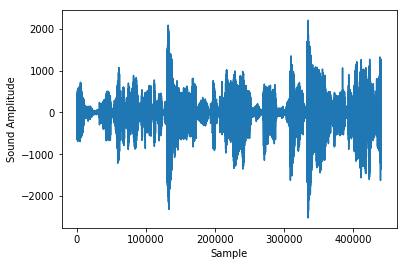

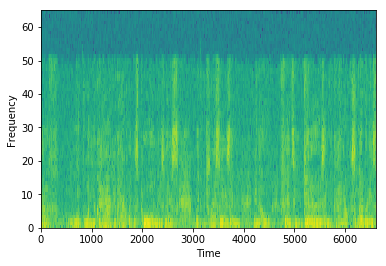

1334it [06:28,  2.81it/s]


In [8]:
main("dfdc_train_part_0")

In [4]:
### HELPER FUNCTIONS VIDEO

def get_model():
    """Returns a Darknet model pretrained on the WIDER dataset, and
    the device on which the model is running (CUDA hopefully)"""
    device = torch_utils.select_device(force_cpu=ONNX_EXPORT)
    torch.backends.cudnn.benchmark = False  # set False for reproducible results
    
    # Initialize model with pretrained weights
    model = Darknet(CFG, 416)
    model.load_state_dict(torch.load(WEIGHTS, map_location=device)['model'])
    model.to(device).eval()
    return model, device

def get_dataloader(invid):
    """
    Returns batches of image size 416"""
    return LoadWebcam(img_size=416, half=False, pipe=invid)

def write_face_samples(model, dataloader, output_path, device):
    """
    Writes to disk a series of faces detected in a video sample"""
    if os.path.isdir(output_path) : return
    os.mkdir(output_path)
    
    # Confidence and non_max_suppression threshold 
    conf_thres = 0.8
    nms_thres = 0.6
    
    # Looping over frames of video
    for i, (path, img, im0, vid_cap) in enumerate(dataloader):
        # Getting bounding box preds
        img = torch.from_numpy(img).unsqueeze(0).to(device)
        pred, _ = model(img)
        
        # Removing overlapping bounding boxes and denoising
        det = non_max_suppression(pred.float(), conf_thres, nms_thres)[0]
        if det is not None and len(det) > 0:
            # Scaling bounding box coords to raw image size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
            
            # Looping over bounding boxes, extracting faces from the video frame
            face_ix = 0
            for *xyxy, conf, cls_conf, cls in det:
                (startX, startY, endX, endY) = int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])
                face = im0[startY:endY, startX:endX]
                
                save_path = f"{output_path}webcam_{i}_{face_ix}.jpg"
                cv2.imwrite(save_path, face)
                face_ix += 1